In [57]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

## To Do list
- LS370 still crashes after around 7hrs continuous operation
- To better sync the T1256 and T8, we should ask py to generate below txt file
 - filename: CH1 T 18-11-19.txt
 - lines: 18-11-19,00:01:48,5.618350E+1

- Make new cables
    - Remake the I, V splitting Fisher probing line
    - Remake ISO, COM x2 Fisher-BNC cables
- Maintain old sample holder
    - Fix pin 5b
- Try to see if we can fix the wiring in the fridge. Currently ch 5ab open, ch 10ab short.
- Make new sample holder

In [192]:
for i in range(10):
    with open('Rt.txt','a') as fp:
        fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(i*1e5), time.localtime())+'\n')
    fp.close
    time.sleep(1*60)
time.sleep(5*60)

for i in range(15):
    with open('Rt.txt','a') as fp:
        fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(i*1e4), time.localtime())+'\n')
    fp.close
    time.sleep(1*60)

In [159]:
import time
import datetime
import matplotlib.pyplot as plt

def getTt(rootpath, filedate = '21-11-19', Tch = 8):
    filename = r'\\'+filedate+'\CH{} T '.format(Tch)+filedate+'.log'
    filepath = rootpath+filename

    dateori = datetime.datetime(2019,11,21,0,0,0)
    dhrslst = []
    dlst = []
    Tlst = []
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            l = line.strip()
            d = datetime.datetime(int(l.split(',')[0].split('-')[2])+2000,
                                  int(l.split(',')[0].split('-')[1]),
                                  int(l.split(',')[0].split('-')[0]),
                                  int(l.split(',')[1].split(':')[0]),
                                  int(l.split(',')[1].split(':')[1]),
                                  int(l.split(',')[1].split(':')[2]))
            T = float(l.split(',')[2])
            dhrslst.append(((d-dateori).days *86400 + (d-dateori).seconds)/60/60)
            dlst.append(d)
            Tlst.append(T)
            line = fp.readline()
            cnt += 1
    fp.close()
    return (dhrslst, dlst, Tlst)


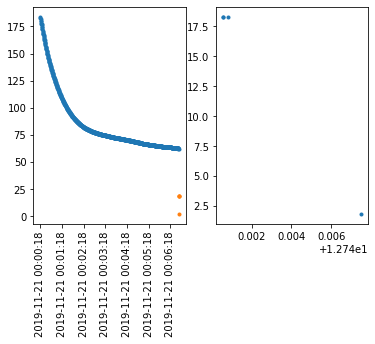

In [185]:
rootpath = r'\\SERIN135_DR-PC\BlueFors\Temperature Log'
filedate = '21-11-19'

dhrslst1, dlst1, Tlst1 = getTt(rootpath=rootpath, filedate = '21-11-19', Tch = 1)
dhrslst8, dlst8, Tlst8 = getTt(rootpath=rootpath, filedate = '21-11-19', Tch = 8)
plt.close('all')   
f,ax = plt.subplots(1,2)

ax[0].plot(dlst1,Tlst1,'.')
ax[0].plot(dlst8,Tlst8,'.')
ax[0].set_xticklabels(dlst,rotation='vertical')
ax[1].plot(dhrslst8,Tlst8,'.')
plt.show()


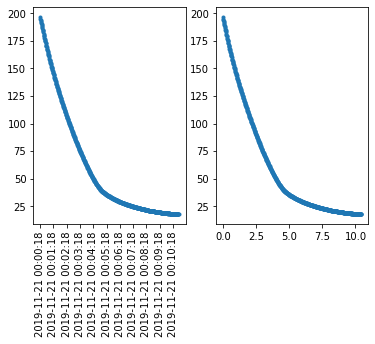

In [132]:
import time
import datetime
import matplotlib.pyplot as plt

Tch = 2
filedate = '21-11-19'

rootpath = r'\\SERIN135_DR-PC\BlueFors\Temperature Log'
filename = r'\\'+filedate+'\CH{} T '.format(Tch)+filedate+'.log'
filepath = rootpath+filename

dateori = datetime.datetime(2019,11,21,0,0,0)
dhrslst = []
dlst = []
Tlst = []
with open(filepath) as fp:
    line = fp.readline()
    cnt = 1
    while line:
        l = line.strip()
        d = datetime.datetime(int(l.split(',')[0].split('-')[2])+2000,
                              int(l.split(',')[0].split('-')[1]),
                              int(l.split(',')[0].split('-')[0]),
                              int(l.split(',')[1].split(':')[0]),
                              int(l.split(',')[1].split(':')[1]),
                              int(l.split(',')[1].split(':')[2]))
        T = float(l.split(',')[2])
        dhrslst.append(((d-dateori).days *86400 + (d-dateori).seconds)/60/60)
        dlst.append(d)
        Tlst.append(T)
        line = fp.readline()
        cnt += 1


plt.close('all')   
f,ax = plt.subplots(1,2)

ax[0].plot(dlst,Tlst,'.')
ax[0].set_xticklabels(dlst,rotation='vertical')
ax[1].plot(dhrslst,Tlst,'.')
plt.show()


In [133]:
import qcodes as qc
from qcodes.dataset.database import initialise_database
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from si_prefix import si_format

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


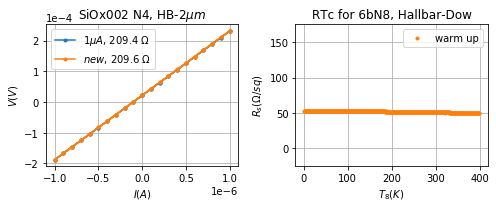

In [134]:
SAMPLE = 'O2N4' #1ab,1a2b
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

devW, devL, devTHK = 3.06e-6, 12.2e-6, 48e-9

labelL = ['$1\mu A$',
          '$new$']
for i,v in enumerate([8,11]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].title.set_text('SiOx002 N4, HB-$2\mu m$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',
          'warm up',
          'cool down, $T_C = 1.95K$']
for i,v in enumerate([14]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    T = np.linspace(1,len(data[0][0]['data']),len(data[0][0]['data']))
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i], color = 'C{}'.format(1-i))#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].title.set_text('RTc for 6bN8, Hallbar-Dow')
ax[1].set_ylim(-25,175)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()